# Convolutional Neural Network (CNN)

Implementation of CNN autoencoder for anomaly detection in satellite timeseries. 

By: Moa Tennberg & Lovisa Ekeroot

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import math
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import graphical tools
import matplotlib.pyplot as plt

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special

py.offline.init_notebook_mode(connected = True)

### Data preparation

In [2]:
# Import datasets and create dataframes 

path_machine = path_machine # path of realKnownCause/machine_temperature_system_failure.csv 

path_cloud_train = path_cloud_train # path of realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv

path_cloud_test = path_cloud_test # path of realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv

data_used = 'machine'

def dataframe_creator(data_name):
    if data_name == 'cloud':
        df_train = pd.read_csv(path_cloud_train, parse_dates = True, index_col = 'timestamp')
        df_test = pd.read_csv(path_cloud_test, parse_dates = True, index_col = 'timestamp')
        
        filename = ['realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv', 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv']
        
    elif data_name == 'machine': 
        df = pd.read_csv(path_machine, parse_dates = True, index_col = 'timestamp')
        
        df_train = df[:round(len(df)*0.8)] # 75% training data
        df_test = df[round(len(df)*0.8):] # 25% test data
        
        filename = 'realKnownCause/machine_temperature_system_failure.csv'
        
    return filename, df_train, df_test

In [3]:
filename, df_train, df_test = dataframe_creator(data_used)

# Quick look at the data
print(filename)
print(df_train.head())

print(df_test.head())

realKnownCause/machine_temperature_system_failure.csv
                         value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836
                         value
timestamp                     
2014-02-03 21:15:00  98.740763
2014-02-03 21:20:00  96.882824
2014-02-03 21:25:00  98.841761
2014-02-03 21:30:00  97.474381
2014-02-03 21:35:00  97.492345


In [4]:
# Standardize and parse training and test data
def parse_and_standardize(train, test):
    train_mean = train.mean()
    train_std = train.std()
    
    stand_train = (train - train_mean)/train_std
    stand_test = (test - train_mean)/train_std
    
    return stand_train, stand_test

stand_train, stand_test = parse_and_standardize(df_train, df_test)

In [5]:
# Quick look at the standardized data
print(stand_train.head())
print(stand_test.head())

                        value
timestamp                    
2013-12-02 21:15:00 -0.987640
2013-12-02 21:20:00 -0.906256
2013-12-02 21:25:00 -0.806411
2013-12-02 21:30:00 -0.636970
2013-12-02 21:35:00 -0.537053
                        value
timestamp                    
2014-02-03 21:15:00  1.093956
2014-02-03 21:20:00  0.937843
2014-02-03 21:25:00  1.102443
2014-02-03 21:30:00  0.987548
2014-02-03 21:35:00  0.989058


In [6]:
# Import anomalies

labels_path =  '/Users/moa/Desktop/Kandidatarbete 2021/Dataset/NAB-master/labels/combined_labels.json'

with open(labels_path, 'r') as f:
    anomalies_timestamp = json.load(f)
    
if data_used == 'cloud':
    train_anomalies = df_train[df_train.index.isin(anomalies_timestamp[filename[0]])]
    test_anomalies = df_test[df_test.index.isin(anomalies_timestamp[filename[1]])]
    
elif data_used == 'machine':
    train_anomalies = df_train[df_train.index.isin(anomalies_timestamp[filename])]
    test_anomalies = df_test[df_test.index.isin(anomalies_timestamp[filename])]
    
# View position of anomalies
print(train_anomalies.head())
print(test_anomalies.head())

                          value
timestamp                      
2013-12-11 06:00:00  102.736214
2013-12-16 17:25:00    2.084721
2014-01-28 13:15:00   53.935329
                         value
timestamp                     
2014-02-08 14:30:00  25.887752


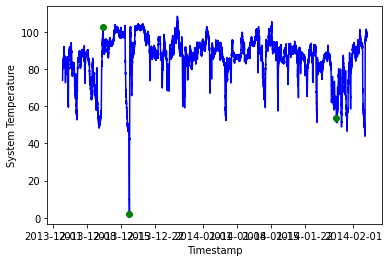

In [7]:
plt.plot(df_train.index, df_train.value, c = 'b', label = 'Non-anomaly', zorder = -1)
plt.scatter(train_anomalies.index, train_anomalies.value, c = 'g', label = 'Anomaly', zorder = 1)
plt.xlabel('Timestamp')
plt.ylabel('System Temperature')

plt.show()

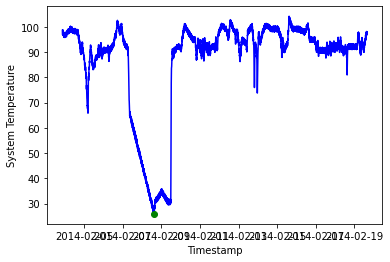

In [8]:
plt.plot(df_test.index, df_test.value, c = 'b', label = 'Non-anomaly', zorder = -1)
plt.scatter(test_anomalies.index, test_anomalies.value, c = 'g', label = 'Anomaly', zorder = 1)
plt.xlabel('Timestamp')
plt.ylabel('System Temperature')

plt.show()

### Create Convolutional Model

In [9]:
# Create sequences
delta_t = 288 # define time steps

# Generated training sequences for use in the model
def create_sequences(values, time_steps = delta_t):
    output = []
    
    for i in range(len(values) - time_steps):
        output.append(values[i: (i+time_steps)])
    
    return np.stack(output)

x_train = create_sequences(stand_train.values)
print('Training input shape: ', x_train.shape)

Training input shape:  (17868, 288, 1)


In [10]:
# Build the model

cnn_model = keras.Sequential(
    [
        layers.Input(shape = (x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters = 32, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu'
        ),
        layers.Dropout(rate = 0.2),
        layers.Conv1D(
            filters = 16, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu'
        ),
        layers.Conv1DTranspose(
            filters = 16, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu'
        ),
        layers.Dropout(rate = 0.2),
        layers.Conv1DTranspose(
            filters = 32, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu'
        ),
        layers.Conv1DTranspose(filters = 1, kernel_size = 7, padding = 'same'),
    ]
)

cnn_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = 'mae')
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

### Train the network

In [11]:
history = cnn_model.fit(
    x_train,
    x_train,
    epochs = 50, 
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')
    ]
)

Epoch 1/50
126/126 [==============================] - 9s 63ms/step - loss: 0.3530 - val_loss: 0.0995
Epoch 2/50
126/126 [==============================] - 7s 55ms/step - loss: 0.0884 - val_loss: 0.0917
Epoch 3/50
126/126 [==============================] - 6s 50ms/step - loss: 0.0758 - val_loss: 0.1193
Epoch 4/50
126/126 [==============================] - 7s 55ms/step - loss: 0.0701 - val_loss: 0.1033
Epoch 5/50
126/126 [==============================] - 8s 63ms/step - loss: 0.0652 - val_loss: 0.1359
Epoch 6/50
126/126 [==============================] - 8s 60ms/step - loss: 0.0602 - val_loss: 0.1911
Epoch 7/50
126/126 [==============================] - 7s 59ms/step - loss: 0.0572 - val_loss: 0.1863


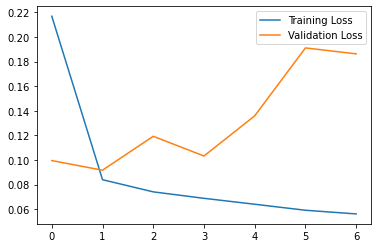

In [12]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

### Detect anomalies

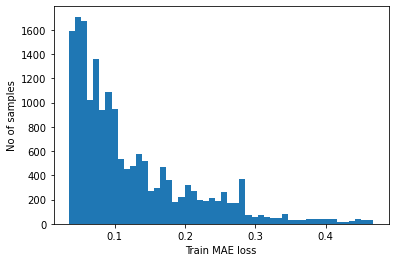

Reconstruction error threshold:  0.503694135572958


In [13]:
# Calculate train MAE loss
x_train_pred = cnn_model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)

plt.hist(train_mae_loss, bins = 50)
plt.xlabel('Train MAE loss')
plt.ylabel('No of samples')
plt.show()

# Get reconstruction loss threshold
prediction_error = abs(x_train - x_train_pred)
threshold = np.mean(prediction_error) + 3 * np.std(prediction_error)
print('Reconstruction error threshold: ', threshold)

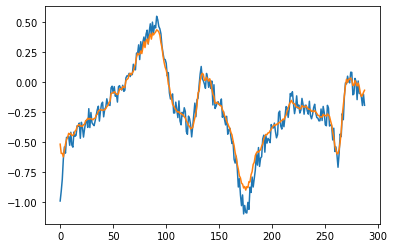

In [14]:
# Compare reconstruction

# Checking how the first sequence is learn
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Find anomalies in training data

In [15]:
# Detect all samples which are anomalies
train_anomalies = train_mae_loss > threshold

print('Number of anomaly samples: ', np.sum(train_anomalies))
print('Indices of anomaly samples: ', np.where(train_anomalies))

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64), array([], dtype=int64))


In [16]:
# Plot anomalies

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
train_anomalous_data_indices = []

for data_idx in range(delta_t - 1, len(stand_train) - delta_t + 1):
    if np.all(train_anomalies[data_idx - delta_t + 1: data_idx]):
        train_anomalous_data_indices.append(data_idx)

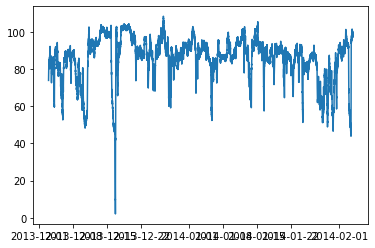

In [17]:
df_train_subset = df_train.iloc[train_anomalous_data_indices]
fig, ax = plt.subplots()
plt.plot(df_train.index, df_train.value, zorder = -1)
plt.scatter(df_train_subset.index, df_train_subset.value, zorder = 1, c = 'red')
plt.show()

### Apply model to validation data

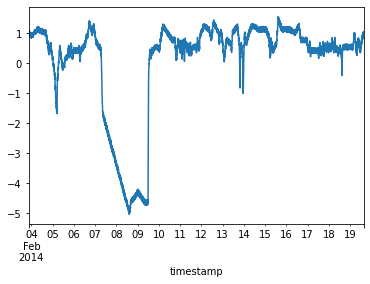

Test input shape:  (4251, 288, 1)


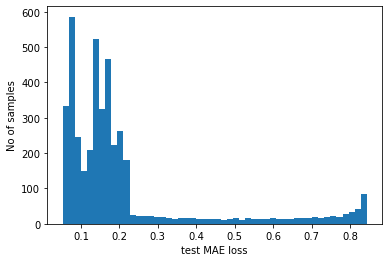

In [18]:
fig, ax = plt.subplots()
stand_test.plot(legend = False, ax = ax)
plt.show()

# Create sequences from test values
x_test = create_sequences(stand_test.values)
print('Test input shape: ', x_test.shape)

# Get test MAE loss
x_test_pred = cnn_model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins = 50)
plt.xlabel('test MAE loss')
plt.ylabel('No of samples')
plt.show()

In [19]:
# Detect all samples which are anomalies
anomalies = test_mae_loss > threshold
print('Number of anomaly samples: ', np.sum(anomalies))

Number of anomaly samples:  461


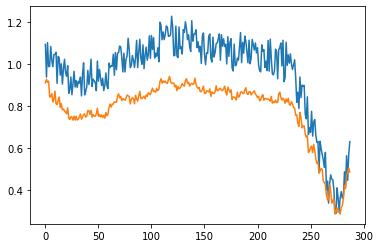

In [20]:
# Compare reconstruction

# Checking how the first sequence is learnt
plt.plot(x_test[0])
plt.plot(x_test_pred[0])
plt.show()

### Find anomalies in test data

In [21]:
# Plot anomalies

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []

for data_idx in range(delta_t - 1, len(stand_test) - delta_t + 1):
    if np.all(anomalies[data_idx - delta_t + 1: data_idx]):
        anomalous_data_indices.append(data_idx)

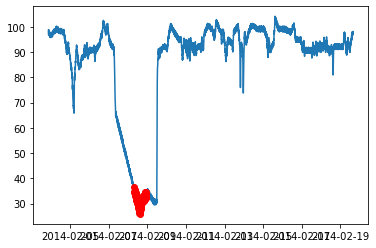

In [22]:
df_test_subset = df_test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
plt.plot(df_test.index, df_test.value, zorder = -1)
plt.scatter(df_test_subset.index, df_test_subset.value, zorder = 1, c = 'red')
plt.show()